### Analysis of HDF5 workloads with Darshan
In this example notebook, we will investigate the impact of different HDF5 I/O strategies on the performance of underlying POSIX accesses to the storage system. Note that this notebook relies on experimental plotting functionality provided by PyDarshan.

In [1]:
import darshan
darshan.enable_experimental()
from darshan.experimental.plots.matplotlib import plot_access_histogram
from darshan.experimental.plots.matplotlib import plot_opcounts

Each of the following examples writes an HDF5 dataset using a simple block decomposition along the lines of the following:
![block decomposition](figs/block.png)
Specifically, 256 total processes decompose a 2-D HDF5 dataset into a 16x16 grid of blocks, with each process responsible for writing a single block. Each block represents a 1024x1024 array of double precision floating point data (i.e., each process writes 8 MiB of data, for an aggregate of 2 GiB).

In [2]:
report_base = darshan.DarshanReport('logs/snyder_h5-block_id511919_4-14-3389-13517322816805000194_1.darshan')

For this base configuration, no optimizations are applied at the HDF5 layer, and each process simply writes their own independent block of data. This results in the following write performance:

In [3]:
base_rec = report_base.records['H5D'].to_dict()[0]
nprocs = report_base.metadata['job']['nprocs']
total_mbytes = base_rec['counters']['H5D_BYTES_WRITTEN']/1024/1024
per_proc_time = base_rec['fcounters']['H5D_F_WRITE_TIME']/nprocs
print("Avg. write b/w: %.4lf MiB/sec" % (total_mbytes/per_proc_time))

Avg. write b/w: 7.6174 MiB/sec


Performance is pretty bad...

How does this workload look at the POSIX layer?

Summarizing... iohist POSIX


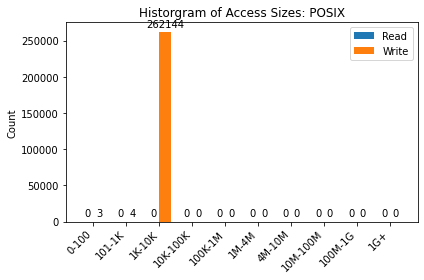

In [4]:
plt = plot_access_histogram(report_base, mod='POSIX')
plt.show()

So, well over 250,000 accesses to the file system, all of less than 10KiB -- this is not an ideal workload for the parallel file system (Lustre in this case).

The issue is that this particular block decomposition strategy results in a lot of seeking around the output file to access a process's block, which is stored noncontiguously in the file. The following figure illustrates this, with write accesses shown with solid arrows and file seeks shown with dashed arrows. Only a single row of a process's block may be read before a seek is used to find the next row.
![block seek](figs/block-seek.png)

### HDF5 chunking
To address this, HDF5 chunking can be used to control how HDF5 dataset elements are stored in the underlying file. For this access pattern, we would instead prefer that whole blocks are written into the file contiguously, rather than interleaved with other blocks. Setting HDF5 chunking parameters that match the file block decomposition can help address performance issues we saw in the previous case.
![block chunk](figs/block-chunk.png)

Avg. write b/w: 69.8529 MiB/sec

Summarizing... iohist POSIX


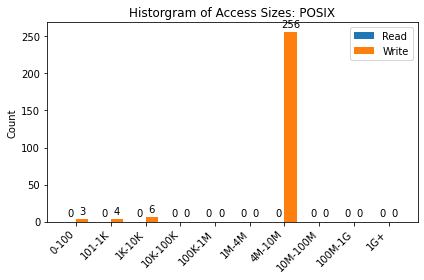

In [5]:
report_chunk = darshan.DarshanReport('logs/snyder_h5-block-chunk_id511919_4-14-3871-13517322816805000194_1.darshan')

chunk_rec = report_chunk.records['H5D'].to_dict()[0]
nprocs = report_chunk.metadata['job']['nprocs']
total_mbytes = chunk_rec['counters']['H5D_BYTES_WRITTEN']/1024/1024
per_proc_time = chunk_rec['fcounters']['H5D_F_WRITE_TIME']/nprocs
print("Avg. write b/w: %.4lf MiB/sec\n" % (total_mbytes/per_proc_time))

plt = plot_access_histogram(report_chunk, mod='POSIX')
plt.show()

This optimization yields an order or magnitude higher performance, enabled by chunking parameters that allow for much larger accesses to the parallel file system -- in this case, entire blocks can be written in a single operation rather than a row at a time.

### HDF5 collective I/O
Another popular optimization for HDF5 workloads is to enable the MPI-IO collective I/O algorithm. With collective I/O, subsets of application processes perform I/O on behalf of all other processes. This optimization can increase performance for many workloads for 2 key reasons: (1) coalescing smaller independent accesses into larger accesses, and (2) limiting the number of processes accessing a file at the same time.
![block coll](figs/block-coll.png)

Avg. write b/w: 183.9809 MiB/sec

Summarizing... iohist POSIX


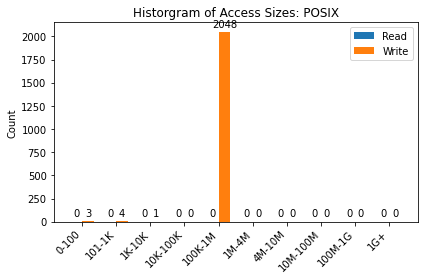

In [6]:
report_coll = darshan.DarshanReport('logs/snyder_h5-block-coll_id511919_4-14-3843-13517322816805000194_1.darshan')

coll_rec = report_coll.records['H5D'].to_dict()[0]
nprocs = report_coll.metadata['job']['nprocs']
total_mbytes = coll_rec['counters']['H5D_BYTES_WRITTEN']/1024/1024
per_proc_time = coll_rec['fcounters']['H5D_F_WRITE_TIME']/nprocs
print("Avg. write b/w: %.4lf MiB/sec\n" % (total_mbytes/per_proc_time))

plt = plot_access_histogram(report_coll, mod='POSIX')
plt.show()

In this case, we see another 3x increase in performance over our previous chunking optimization. Interestingly, this workload yields more POSIX operations of smaller size than in the chunking case. But, the MPI-IO collective I/O algorithm is aware of Lustre striping parameters and is able to generate stripe-aligned accesses that lead to much improved I/O performance.

**GOTCHA**: In some cases, HDF5 may decide internally to ignore a user request to perform collective I/O. Often, this is triggered if a given dataset has different representations in-memory vs in-file. As an example, the previous collective I/O use case was simply modified to store the application's in-memory double-precision floating point data as single-precision floats in-file, a reasonable transformation for applications that don't need to persist high-precision data. 